In [1]:
import os
import json
import pandas as pd
import concurrent.futures

from openai import OpenAI
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [2]:
data_path = './data/'
df = pd.read_csv(data_path + 'train.csv')

In [3]:
df = df.loc[ : , ['content', 'service_waiters_attitude']]

df = df.sample(n = 50, random_state = 520487)

contents = list(df['content'])
labels = list(df['service_waiters_attitude'])
labels = [i + 2 for i in labels]

In [4]:
def get_f1_score(labels, pred):
    return f1_score(labels, pred, labels=[0, 1, 2, 3], average='macro')

In [5]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY", "***"),
    base_url='https://api.xty.app/v1',
)

In [ ]:
# messages=[]
# messages.append({'role': 'system', 'content': "你是一名出色的信息分析工程师，下面是一个餐饮评论的分析任务。"})
# messages.append({'role': 'system', 'content': "请对以下餐饮评论进行分析，并根据评论中对“服务人员态度”的情感倾向给出相应的分类标签。分类标签如下："})
# messages.append({'role': 'system', 'content': "数字'0'表示评论内容未提及“服务人员态度”这一评价对象。数字'1'表示评论内容提及了“服务人员态度”且对其持负面情感。数字'2'表示评论内容提及了“服务人员态度”但没有明显的情感倾向。数字'3'表示评论内容提及了“服务人员态度”且对其持正面情感。"})
# messages.append({'role': 'system', 'content': "请确保在给出分类标签时，考虑到评论者对“服务人员态度”的具体描述和情感态度，你只能回答一个单独的数字，即分类标签，不要添加标点符号等其他内容。"})
# messages.append({"role": "user", "content": "哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，感觉啥都有，杂都不足以形容。随便点些，居然口味什么的都好还可以，价钱自然是便宜当震惊。元宝虾和椒盐九肚鱼都不错吃。不过近来几次么，味道明显没以前好了。冷餐里面一个凉拌海带丝还可以，酸酸甜甜的。镇上也有了些别的大点的饭店，所以不是每次必来了。对了，这家的生意一如既往的超级好，不定位基本吃不到。不过佘山这边的人吃晚饭很早的，所以稍微晚点去就很空了。"})
# messages.append({"role": "assistant", "content": "0"})
# messages.append({'role': 'user', 'content': content[1:-1]})

In [6]:
MODEL = 'gpt-4-turbo'

out_preds = []
out_labels = []

def process_pred(content, label):
    messages=[]
    messages.append({'role': 'system', 'content': "你是一名出色的信息分析工程师，下面是一个餐饮评论的分析任务。"})
    messages.append({'role': 'system', 'content': "请对以下餐饮评论进行分析，并根据评论中对“服务人员态度”的情感倾向给出相应的分类标签。分类标签如下："})
    messages.append({'role': 'system', 'content': "数字'0'表示评论内容未提及“服务人员态度”这一评价对象。数字'1'表示评论内容提及了“服务人员态度”且对其持负面情感。数字'2'表示评论内容提及了“服务人员态度”但没有明显的情感倾向。数字'3'表示评论内容提及了“服务人员态度”且对其持正面情感。"})
    messages.append({'role': 'system', 'content': "请确保在给出分类标签时，考虑到评论者对“服务人员态度”的具体描述和情感态度，你只能回答一个单独的数字，即分类标签，不要添加标点符号等其他内容。"})
    messages.append({'role': 'user', 'content': content[1:-1]})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0.5,
    )
    
    pred = response.choices[0].message.content
    pred = pred[-1:]
    
    return pred, label

# 创建一个线程池  
with concurrent.futures.ThreadPoolExecutor(max_workers = 100) as executor:  # max_workers表示并发数
    pbar = tqdm(total=len(contents))

    # 提交任务到线程池，并获取Future对象列表
    futures = {executor.submit(process_pred, content, label): (content, label) for content, label in zip(contents, labels)}

    # 遍历Future对象列表，获取结果  
    for future in concurrent.futures.as_completed(futures):
        content, label = futures[future]
        try:
            pred, label = future.result()
            out_preds.append(int(pred))
            out_labels.append(label)
            pbar.update(1)
        except Exception as exc:
            print(f'Generated an exception: {exc}')
            pbar.update(1)

    pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
contents[-3:]

['"趁着开业打六折过来尝尝鲜的~很幸运的拿到了最后一个号，然后等了差不多一个小时才轮到我们点餐，由于是开业期间，只限点套餐，因此我们点了二人套餐B组合~\n先说环境吧，装饰的粉可爱了！很符合小猪猪的主题，满满的粉色，非常满足我这个粉红控~桌子相对比较小，两个人是刚好~人多的话可能就有点挤了~\n服务员态度很好！给人的感觉都是精神奕奕的，很有活力~也很贴心的让我找个好角度去拍照美食，赞一个！\n菜品的话，小猪猪组合是三种肉混合，味道都不错，也不会觉得肥！烧汁焗粉丝，味道很浓郁，适合包着菜一起吃~猪猪炒饭，芝士分量很足，拉丝也很完美~青菜不知道有没得续，因为实在好新鲜！如果无限续商家亏死了，所以就不好意思去问了~ 另外，配菜居然没有泡菜！对于热爱泡菜的我来说这点很不满意啊~最后说说水果茶吧，个人觉得味道怪怪的！饮料的选择偏少，建议可以增加~\n两个人吃的饱饱的，打完折才98，太划算了！即使没有打折，价格也很公道~推荐大家去尝试~"',
 '"家里附近的pizza店，新开的，每每路过都想试试，今天特意去帮衬了。这店地址位置方便，就在车站旁边，远远就能看到大招牌。因为是新开的店，店内整体感觉干净，灯光明亮，店员精神面貌饱满，有礼貌，也很热情。我刚进去就向我问好，问我需要，还向我介绍各类的pizza特点和做法，现场还能看到pizza小哥在做pizza呢！！呵呵！！pizza都是现点现做的，需要等大概10几分钟，不过很新鲜。我点最爱的榴莲pizza。打开盖子就闻到阵阵的榴莲飘香，让我垂涎欲滴了。感觉这里的pizza比较真材实料。榴莲芝士都是落足了料，味道很棒棒哒！！尝一口，感觉满满的芝士和榴莲，饼底不像其他pizza那么硬！！我马上就吃了两块了，大满足啊！！呵呵O(∩_∩)O~"',
 '"离办公室还是蛮近的，看点评的名字觉得很有意思，正好想吃川菜，就去了。\n在红街旁边那个楼，在二楼，从大厦的电梯上去就看到了，装修得还是蛮古典的样子，服务员都穿着格格服。\n看了菜单，好象主打是小龙虾，我们没点，要了些家常的菜。\n#毛血旺# 这个挺不错的，料蛮多的，黄鳝用的挺大的，黄喉和午餐肉也都有，香辣够味。\n#千岛玉带# 也很好吃，摆盘也漂亮，就是量不太大。\n#酸汤饺子# 主食点了酸汤饺子，十分好吃，酸汤好开胃"']

In [8]:
out_labels[-3:]

[0, 3, 2]

In [9]:
out_preds[-3:]

[0, 3, 2]

In [10]:
get_f1_score(out_labels, out_preds)

0.5815527065527065

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

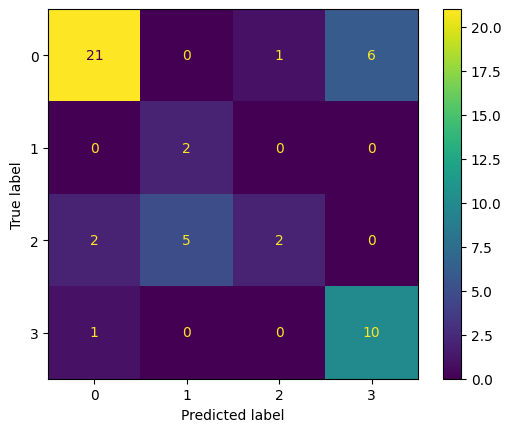

In [12]:
cm = confusion_matrix(out_labels, out_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()